In [1]:
pip install sentence-transformers scikit-learn matplotlib seaborn pandas numpy

Loading model: all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded 13 records
Creating embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Created embeddings with shape: (13, 384)
Running example searches...

Searching for: 'corn production and farming'
Results for: 'corn production and farming'
   rank    code                       title  similarity_score
0     1  111150                Corn Farming          0.777598
1     2   11115               Corn FarmingT          0.664595
2     3    1111  Oilseed and Grain FarmingT          0.575201
3     4     111            Crop ProductionT          0.570104
4     5  111140               Wheat Farming          0.569921


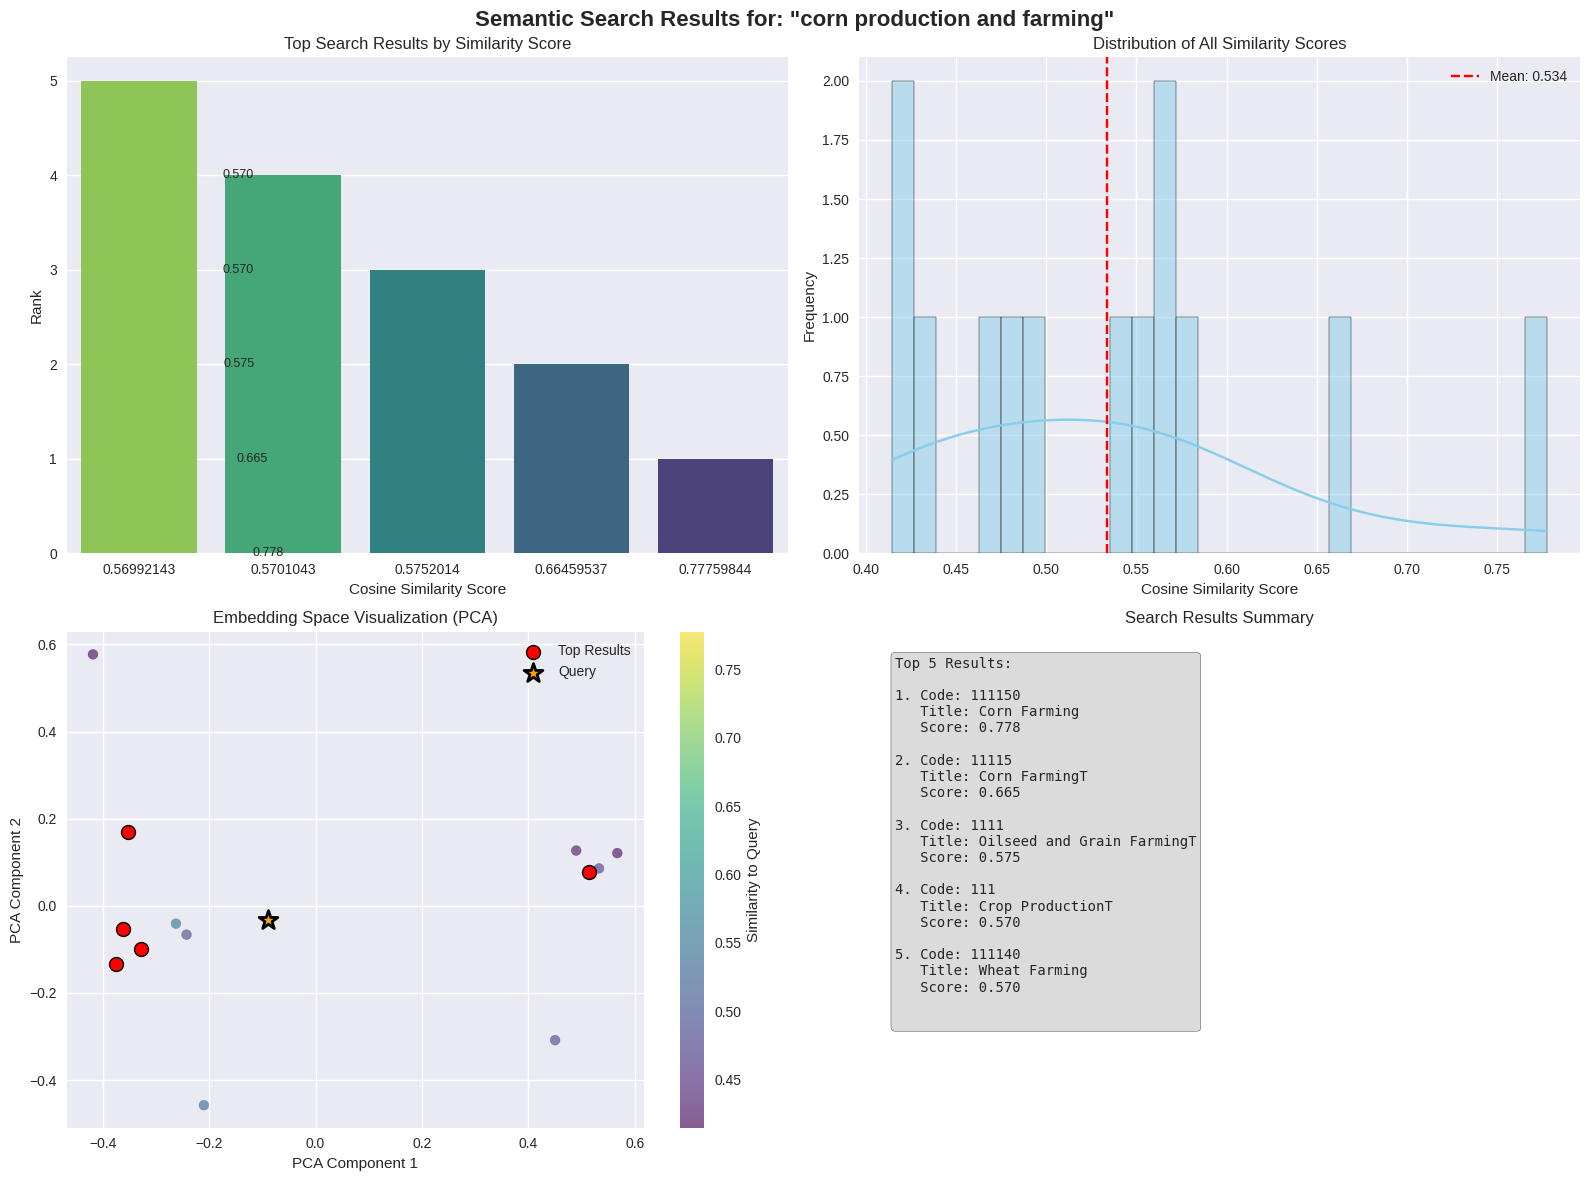


Searching for: 'vegetable crops'
Results for: 'vegetable crops'
   rank    code                             title  similarity_score
0     1     111                  Crop ProductionT          0.580414
1     2  111130          Dry Pea and Bean Farming          0.570258
2     3  111110                   Soybean Farming          0.542635
3     4  111120  Oilseed (except Soybean) Farming          0.541119
4     5  111150                      Corn Farming          0.532877


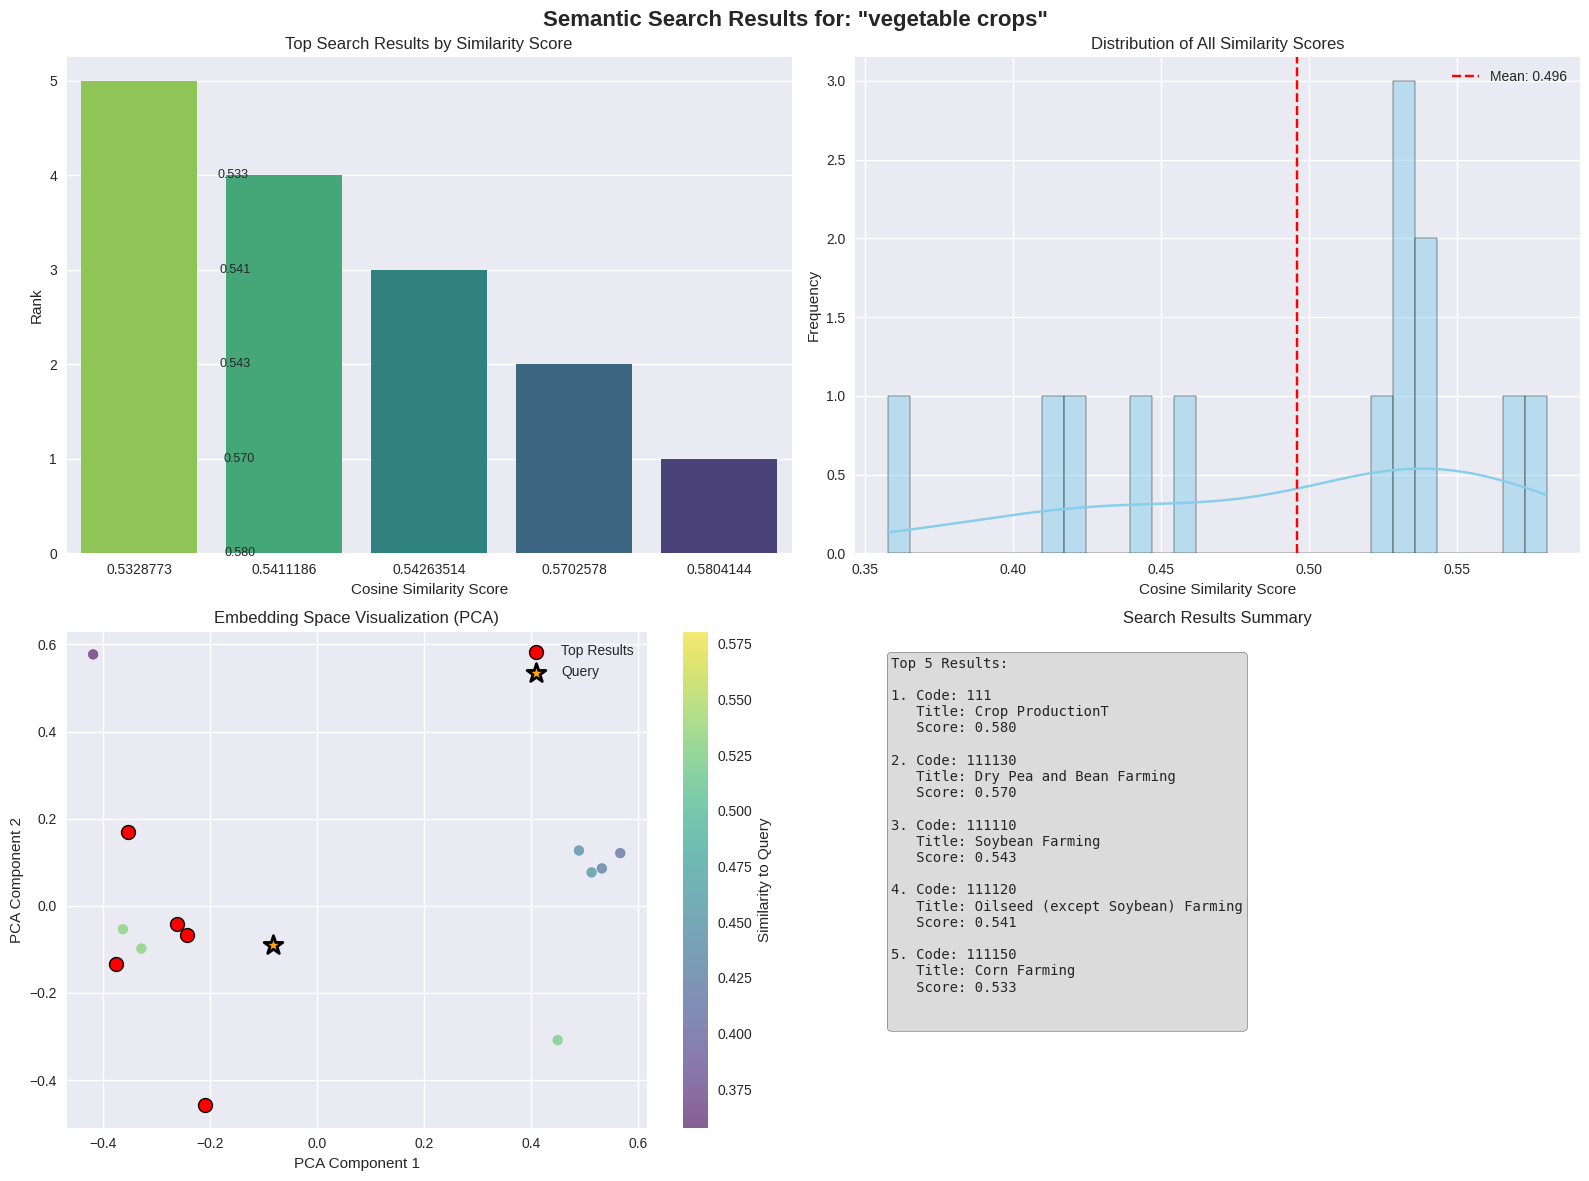


Searching for: 'grain farming operations'
Results for: 'grain farming operations'
   rank    code                       title  similarity_score
0     1    1111  Oilseed and Grain FarmingT          0.655642
1     2  111140               Wheat Farming          0.649024
2     3  111150                Corn Farming          0.582036
3     4  111130    Dry Pea and Bean Farming          0.550979
4     5   11114              Wheat FarmingT          0.539281


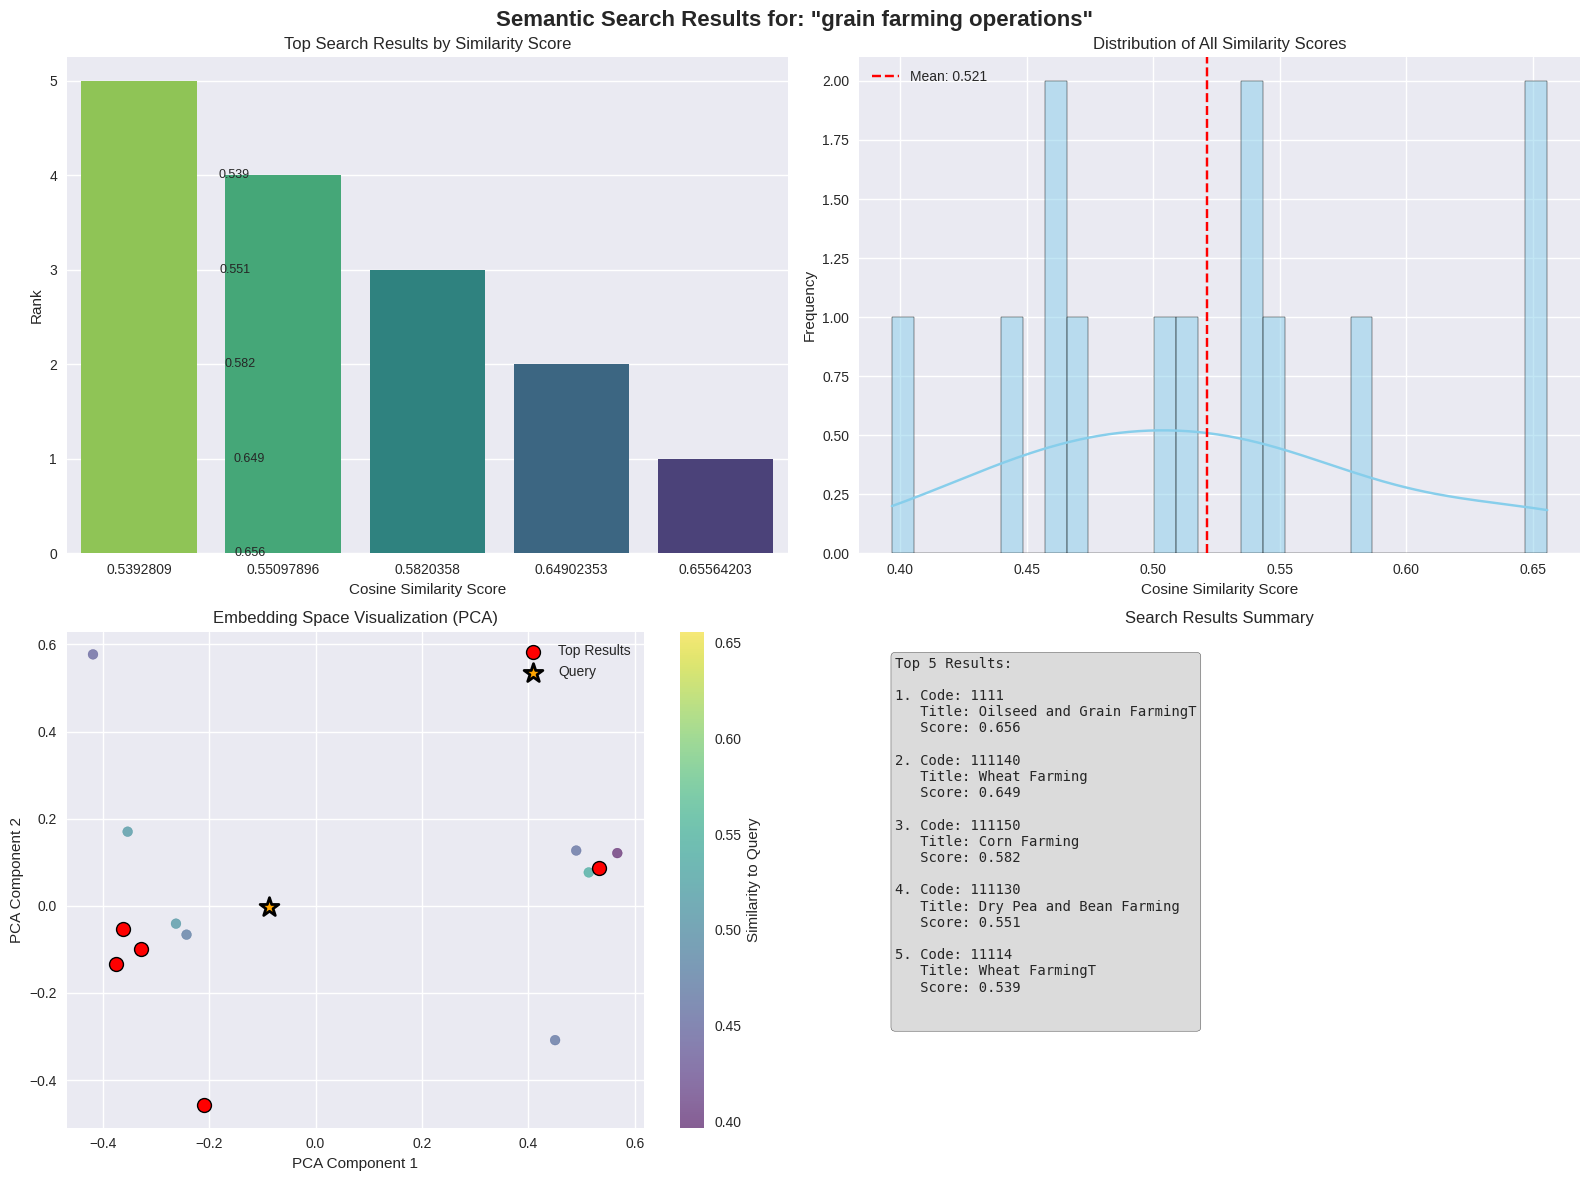


=== NAICS Semantic Search ===
Type 'quit' to exit

Enter your search query: Horses and Other Equine ProductionT
Searching for: 'Horses and Other Equine ProductionT'

Top 5 results for 'Horses and Other Equine ProductionT':

1. [11] Agriculture, Forestry, Fishing and HuntingT
   Similarity: 0.311
   Description: The Sector as a Whole. The Agriculture, Forestry, Fishing and Hunting sector comprises establishments primarily engaged in growing crops, raising animals, harvesting timber, and harvesting fish and ot...

2. [1111] Oilseed and Grain FarmingT
   Similarity: 0.290
   Description: This industry group comprises establishments primarily engaged in (1) growing oilseed and/or grain crops and/or (2) producing oilseed and grain seeds. These crops have an annual life cycle and are typ...

3. [111140] Wheat Farming
   Similarity: 0.271
   Description: This industry comprises establishments primarily engaged in growing wheat and/or producing wheat seeds.

4. [11114] Wheat FarmingT
   Simil

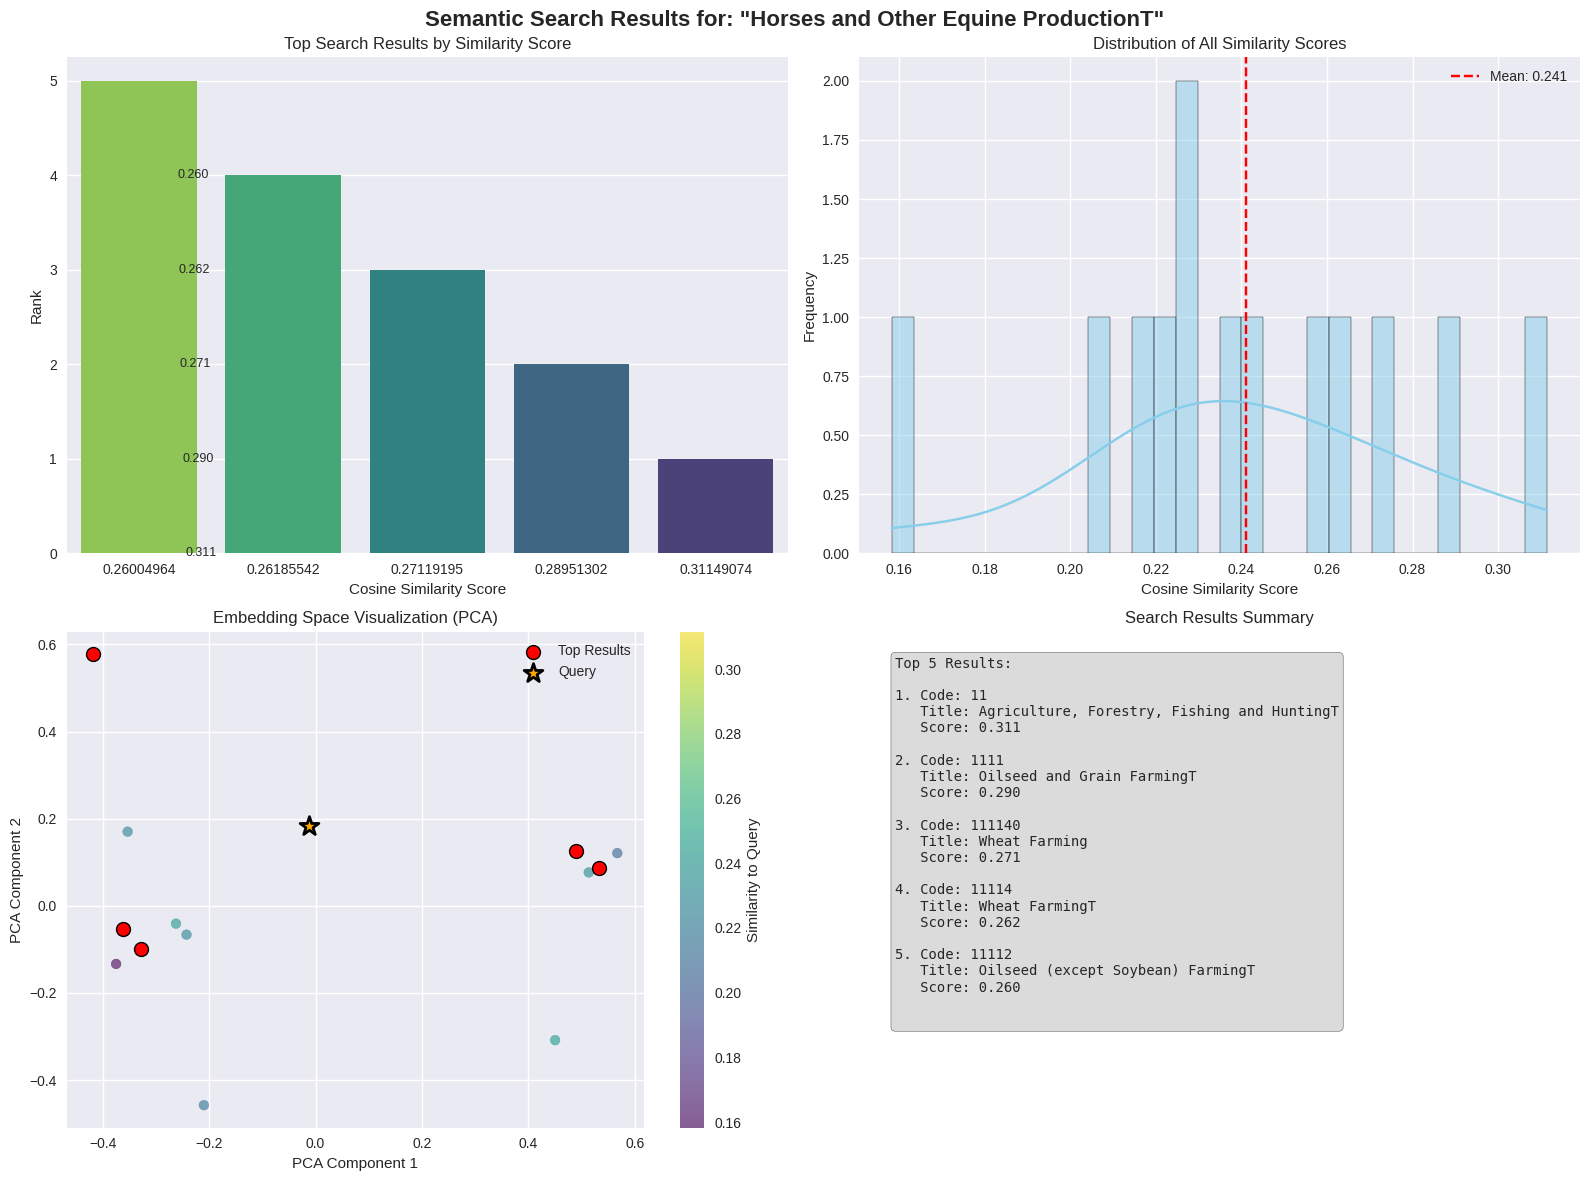

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

class NAICSSemanticSearch:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        """
        Initialize the semantic search system
        """
        print(f"Loading model: {model_name}")
        self.model = SentenceTransformer(model_name)
        self.data = None
        self.embeddings = None
        self.text_column = None

    def load_data(self, file_path=None, data=None):
        """
        Load NAICS data from file or dataframe
        """
        if data is not None:
            # If data is provided directly (for your case)
            self.data = data
        else:
            # Load from CSV file
            self.data = pd.read_csv(file_path)

        # Create a combined text field for better search
        self.data['combined_text'] = (
            self.data['2022 NAICS US Title'].astype(str) + " " +
            self.data['Description'].astype(str)
        )
        self.text_column = 'combined_text'
        print(f"Loaded {len(self.data)} records")
        return self.data

    def create_embeddings(self):
        """
        Convert all text data to embeddings
        """
        print("Creating embeddings...")
        texts = self.data[self.text_column].tolist()
        self.embeddings = self.model.encode(texts, show_progress_bar=True)
        print(f"Created embeddings with shape: {self.embeddings.shape}")
        return self.embeddings

    def search(self, query, top_k=5):
        """
        Perform semantic search
        """
        print(f"Searching for: '{query}'")

        # Convert query to embedding
        query_embedding = self.model.encode([query])

        # Calculate cosine similarity
        similarities = cosine_similarity(query_embedding, self.embeddings)[0]

        # Get top k results
        top_indices = np.argsort(similarities)[::-1][:top_k]

        # Create results dataframe
        results = []
        for i, idx in enumerate(top_indices):
            result = {
                'rank': i + 1,
                'code': self.data.iloc[idx]['2022 NAICS US   Code'],
                'title': self.data.iloc[idx]['2022 NAICS US Title'],
                'description': self.data.iloc[idx]['Description'][:200] + "..." if len(self.data.iloc[idx]['Description']) > 200 else self.data.iloc[idx]['Description'],
                'similarity_score': similarities[idx]
            }
            results.append(result)

        results_df = pd.DataFrame(results)
        return results_df, similarities, top_indices

    def plot_results(self, query, results_df, similarities, top_indices, method='PCA'):
        """
        Visualize search results using seaborn style plots
        """
        # Set seaborn style
        plt.style.use('seaborn-v0_8')
        sns.set_palette("husl")

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Semantic Search Results for: "{query}"', fontsize=16, fontweight='bold')

        # 1. Top Results Bar Plot
        ax1 = axes[0, 0]
        sns.barplot(data=results_df, x='similarity_score', y='rank',
                   palette='viridis_r', ax=ax1)
        ax1.set_title('Top Search Results by Similarity Score')
        ax1.set_xlabel('Cosine Similarity Score')
        ax1.set_ylabel('Rank')

        # Add text annotations
        for i, (score, rank) in enumerate(zip(results_df['similarity_score'], results_df['rank'])):
            ax1.text(score + 0.01, rank - 1, f'{score:.3f}',
                    va='center', fontsize=9)

        # 2. Similarity Score Distribution
        ax2 = axes[0, 1]
        sns.histplot(similarities, bins=30, kde=True, ax=ax2, color='skyblue')
        ax2.axvline(similarities.mean(), color='red', linestyle='--',
                   label=f'Mean: {similarities.mean():.3f}')
        ax2.set_title('Distribution of All Similarity Scores')
        ax2.set_xlabel('Cosine Similarity Score')
        ax2.set_ylabel('Frequency')
        ax2.legend()

        # 3. 2D Visualization of embeddings
        ax3 = axes[1, 0]

        # Reduce dimensionality for visualization
        if method.upper() == 'PCA':
            reducer = PCA(n_components=2, random_state=42)
        else:
            reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(self.embeddings)-1))

        embeddings_2d = reducer.fit_transform(self.embeddings)
        query_embedding_2d = reducer.transform(self.model.encode([query]).reshape(1, -1))

        # Plot all points
        scatter = ax3.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                            c=similarities, cmap='viridis', alpha=0.6, s=50)

        # Highlight top results
        top_embeddings_2d = embeddings_2d[top_indices]
        ax3.scatter(top_embeddings_2d[:, 0], top_embeddings_2d[:, 1],
                   c='red', s=100, marker='o', edgecolors='black',
                   linewidth=1, label='Top Results')

        # Plot query point
        ax3.scatter(query_embedding_2d[0, 0], query_embedding_2d[0, 1],
                   c='orange', s=200, marker='*', edgecolors='black',
                   linewidth=2, label='Query')

        ax3.set_title(f'Embedding Space Visualization ({method})')
        ax3.set_xlabel(f'{method} Component 1')
        ax3.set_ylabel(f'{method} Component 2')
        ax3.legend()

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax3)
        cbar.set_label('Similarity to Query')

        # 4. Top Results Details
        ax4 = axes[1, 1]
        ax4.axis('off')

        # Create a text summary of top results
        summary_text = "Top 5 Results:\n\n"
        for _, row in results_df.head().iterrows():
            summary_text += f"{row['rank']}. Code: {row['code']}\n"
            summary_text += f"   Title: {row['title']}\n"
            summary_text += f"   Score: {row['similarity_score']:.3f}\n\n"

        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        ax4.set_title('Search Results Summary')

        plt.tight_layout()
        plt.show()

    def interactive_search(self):
        """
        Interactive search interface
        """
        print("\n=== NAICS Semantic Search ===")
        print("Type 'quit' to exit")

        while True:
            query = input("\nEnter your search query: ").strip()

            if query.lower() == 'quit':
                print("Goodbye!")
                break

            if not query:
                print("Please enter a valid query.")
                continue

            # Perform search
            results_df, similarities, top_indices = self.search(query)

            # Display results
            print(f"\nTop 5 results for '{query}':")
            print("=" * 50)
            for _, row in results_df.iterrows():
                print(f"\n{row['rank']}. [{row['code']}] {row['title']}")
                print(f"   Similarity: {row['similarity_score']:.3f}")
                print(f"   Description: {row['description']}")

            # Ask if user wants to see visualization
            viz_choice = input("\nShow visualization? (y/n): ").strip().lower()
            if viz_choice == 'y':
                method_choice = input("Choose method (PCA/TSNE) [PCA]: ").strip().upper() or 'PCA'
                self.plot_results(query, results_df, similarities, top_indices, method_choice)

def main():
    # Sample data based on your provided dataset
    data = {
        '2022 NAICS US   Code': [
            '11', '111', '1111', '11111', '111110', '11112', '111120',
            '11113', '111130', '11114', '111140', '11115', '111150'
        ],
        '2022 NAICS US Title': [
            'Agriculture, Forestry, Fishing and HuntingT',
            'Crop ProductionT',
            'Oilseed and Grain FarmingT',
            'Soybean FarmingT',
            'Soybean Farming',
            'Oilseed (except Soybean) FarmingT',
            'Oilseed (except Soybean) Farming',
            'Dry Pea and Bean FarmingT',
            'Dry Pea and Bean Farming',
            'Wheat FarmingT',
            'Wheat Farming',
            'Corn FarmingT',
            'Corn Farming'
        ],
        'Description': [
            "The Sector as a Whole. The Agriculture, Forestry, Fishing and Hunting sector comprises establishments primarily engaged in growing crops, raising animals, harvesting timber, and harvesting fish and other animals from a farm, ranch, or their natural habitats.",
            "Industries in the Crop Production subsector grow crops mainly for food and fiber. The subsector comprises establishments, such as farms, orchards, groves, greenhouses, and nurseries, primarily engaged in growing crops, plants, vines, or trees and their seeds.",
            "This industry group comprises establishments primarily engaged in (1) growing oilseed and/or grain crops and/or (2) producing oilseed and grain seeds. These crops have an annual life cycle and are typically grown in open fields.",
            "See industry description for 111110.",
            "This industry comprises establishments primarily engaged in growing soybeans and/or producing soybean seeds.",
            "See industry description for 111120.",
            "This industry comprises establishments primarily engaged in growing fibrous oilseed producing plants and/or producing oilseed seeds, such as sunflower, safflower, flax, rape, canola, and sesame.",
            "See industry description for 111130.",
            "This industry comprises establishments primarily engaged in growing dry peas, beans, and/or lentils.",
            "See industry description for 111140.",
            "This industry comprises establishments primarily engaged in growing wheat and/or producing wheat seeds.",
            "See industry description for 111150.",
            "This industry comprises establishments primarily engaged in growing corn (except sweet corn) and/or producing corn seeds."
        ]
    }

    # Initialize the search system
    search_system = NAICSSemanticSearch()

    # Load data
    df = pd.DataFrame(data)
    search_system.load_data(data=df)

    # Create embeddings
    search_system.create_embeddings()

    # Example searches with visualization
    example_queries = [
        "corn production and farming",
        "vegetable crops",
        "grain farming operations"
    ]

    print("Running example searches...")
    for query in example_queries:
        print(f"\n{'='*60}")
        results_df, similarities, top_indices = search_system.search(query)
        print(f"Results for: '{query}'")
        print(results_df[['rank', 'code', 'title', 'similarity_score']])

        # Show visualization
        search_system.plot_results(query, results_df, similarities, top_indices)

    # Start interactive mode
    search_system.interactive_search()

if __name__ == "__main__":
    # Required packages (install if not available):
    # pip install sentence-transformers scikit-learn matplotlib seaborn pandas numpy

    main()